# Simple Genetic Algorithms

**George Lifchits**

WLU CP468: Artificial Intelligence

December 9, 2015

In [1]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# SGA Implementation

## Utilities
First we need utilities to generate the random strings that SGA operates on.

In [2]:
import random


def coin(prob):
    """
    Performs a biased coin toss.
    :param prob: [0 ≤ float ≤ 1]
    :returns: [bool] True with probability `prob` and otherwise False
    """
    # random.random() yields a float between 0 and 1
    return random.random() < prob


def random_string(length):
    """
    :param length: [int] length of random string
    :returns: [string] random string consisting of "0" and "1"
    """
    return ''.join('0' if coin(0.5) else '1' for _ in range(length))
    

def generate_sample_population(number, length):
    """
    :param number: [int] number of strings to return
    :param length: [int] length of the strings to return
    :returns: a random list of binary strings
    """
    return [random_string(length) for _ in range(number)]

## Reproduction

One of the main three operators in SGA.

In [3]:
MIN = 0
MAX = 1


def reproduction(population, fitness_func, min_or_max=MAX):
    """
    Produces a new population from biased roulette reproduction of the given population.
    :param population: [List[str]]
    :param fitness_func: [function: number > 0]
    :param min_or_max: {MIN, MAX}
    :returns: [List[str]]
    """
    # First, we define the probability density (roulette weights) for each
    # member in our given population. 
    
    min_fitness = min(fitness_func(m) for m in population)
    
    def compute_weight(m):
        """
        Subroutine which computes the weight of the biased roulette, which 
        is agnostic of the fitness function. In particular, it will invert
        the fitness value if we are seeking a minimum.
        :param m: [str] member
        """
        fitness = fitness_func(m)
        
        if min_or_max == MAX:
            return fitness - min_fitness + 1
        
        elif min_or_max == MIN:
            return 1 / (fitness - min_fitness + 1)
    
    # Here we normalize the weights to be proportions of the total weighting
    weights = [(m, compute_weight(m)) for m in population]
    total_weights = sum(w for m, w in weights)
    pdf = [(m, w/total_weights) for m, w in weights]
    
    # Now we pick members for the new population.
    # We pick the same number of members as the provided population.
    new_population = []
    for i in range(len(population)):
        rand = random.random()
        cumul = 0
        for member, end_interval in pdf:
            cumul += end_interval
            if rand <= cumul:
                new_population.append(member)
                break # generate next member
    
    return new_population

## Crossover

In [4]:
def crossover(string1, string2, index):
    head1, tail1 = string1[:index], string1[index:]
    head2, tail2 = string2[:index], string2[index:]
    return head1+tail2, head2+tail1


def population_crossover(population, crossover_probability):
    pairs = []
    new_population = []
    while len(population) > 1:
        pairs.append((population.pop(), population.pop()))
    if len(population) == 1:
        new_population.append(population.pop())
        
    for s1, s2 in pairs:
        if not coin(crossover_probability): 
            # don't perform crossover, just add the original pair
            new_population += [s1, s2]
            continue
        idx = random.randint(1, len(s1)-1) # select crossover index
        new_s1, new_s2 = crossover(s1, s2, idx)
        new_population.append(new_s1)
        new_population.append(new_s2)
    return new_population

## Mutation

In [5]:
def mutation(string, probability):
    """
    :param string: the binary string to mutate
    :param probability: [0 ≤ float ≤ 1] the probability of any character being flipped
    :returns: [str] just the input string, possibly with some bits flipped
    """
    flipped = lambda x: '1' if x is '0' else '0'
    chars = (flipped(char) if coin(probability) else char for char in string)
    return ''.join(chars)


def mutate_population(population, prob):
    """
    :param population: [List[str]] population of binary strings
    :returns: [List[str]] just the input population, with some members possibly mutated
    """
    return [mutation(m, prob) for m in population]

In [6]:
def run_genetic_algorithm(fitness, 
                          min_or_max=MAX,
                          num_eras=100, 
                          population_size=20, 
                          chromosome_length=12,
                          crossover_probability=0.4, 
                          mutation_probability=0.005,
                          should_plot=True):
    # initialize population
    population = generate_sample_population(number=population_size, length=chromosome_length)
    # data collection
    populations = []
    
    for i in range(num_eras):
        populations.append(population)
        ##### SGA LOOP #####
        population = reproduction(population, fitness, min_or_max)
        population = population_crossover(population, crossover_probability)
        population = mutate_population(population, mutation_probability)
        ##### END SGA LOOP #####

    # Find the "global optimum" of all the chromosomes we looked at.
    # A better term for this chromosome is "best individual".
    all_chromosomes = {c for pop in populations for c in pop}
    optimizer = min if min_or_max == MIN else max
    global_optimum = optimizer(all_chromosomes, key=fitness)
    fittest_fitness = fitness(global_optimum)
    
    if not should_plot:
        return global_optimum
    
    #############################
    # The SGA execution is done.
    # This is stuff for plotting
    x_axis = range(len(populations))
    fitnesses = [[fitness(m) for m in population] for population in populations]
    mins = [min(f) for f in fitnesses]
    maxs = [max(f) for f in fitnesses]
    avgs = [sum(f)/len(f) for f in fitnesses]

    #optima = [(it, fittest_fitness) for it, pop in enumerate(populations) if global_optimum in pop]
    optima = [(it, fittest_fitness) for it, pop in enumerate(populations) if fittest_fitness in map(fitness, pop)]
    x_optima, y_optima = zip(*optima) # unzip pairs into two sequences
    line_mins, line_maxs, line_avgs = plt.plot(x_axis, mins, 'r--', maxs, 'b--', avgs, 'g-')
    scatter_ceil = plt.scatter(x_optima, y_optima, c='purple')
    ymin, ymax = plt.ylim()
    plt.ylim(0, round(ymax*1.20))
    plt.xlim(0, num_eras)
    plt.legend(
        (line_mins, line_maxs, line_avgs, scatter_ceil), 
        ("min pop fitness", "max pop fitness", "average pop fitness", "occurrences of global optimum"), 
        loc="upper right"
    )
    plt.title("Genetic Algorithm Evolution")
    plt.xlabel('iteration')
    plt.ylabel('fitness')
    plt.show()

    print("Global optimum: {}\nOF = {}".format(global_optimum, fitness(global_optimum)))
    print("Decoded global optimum:", decoder(global_optimum))

# Benchmarks

In [7]:
def dejong_OF(*x):
    return sum(xi**2 for xi in x)


def rosenbrock_OF(*x):
    irange = range(len(x)-1)
    return sum(100 * (x[i+1] - x[i]**2)**2 + (1-x[i])**2 for i in irange)
    

def himmelblau_OF(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


# Provided in http://web.wlu.ca/science/physcomp/ikotsireas/sga/of.txt
nov10 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10])
nov11 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11])
nov12 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12])
nov13 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13])
nov14 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14])
nov15 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15])
nov16 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16])
nov17 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17])
nov18 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18])
nov19 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19])
nov20 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20])
nov21 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20])
nov22 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[3]*a[22]+a[4]*a[22]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[22]+a[2]*a[22]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20]+a[5]*a[22]+a[6]*a[22]+a[7]*a[22]+a[8]*a[22]+a[9]*a[22]+a[10]*a[22]+a[11]*a[22]+a[12]*a[22]+a[13]*a[22]+a[14]*a[22]+a[15]*a[22]+a[16]*a[22]+a[17]*a[22]+a[18]*a[22]+a[19]*a[22]+a[20]*a[22]+a[21]*a[22])
nov23 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[3]*a[22]+a[4]*a[22]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[22]+a[2]*a[22]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20]+a[5]*a[22]+a[6]*a[22]+a[7]*a[22]+a[8]*a[22]+a[9]*a[22]+a[10]*a[22]+a[11]*a[22]+a[12]*a[22]+a[13]*a[22]+a[14]*a[22]+a[15]*a[22]+a[16]*a[22]+a[17]*a[22]+a[18]*a[22]+a[19]*a[22]+a[20]*a[22]+a[21]*a[22]+a[1]*a[23]+a[2]*a[23]+a[3]*a[23]+a[4]*a[23]+a[5]*a[23]+a[6]*a[23]+a[7]*a[23]+a[8]*a[23]+a[9]*a[23]+a[10]*a[23]+a[11]*a[23]+a[12]*a[23]+a[13]*a[23]+a[14]*a[23]+a[15]*a[23]+a[16]*a[23]+a[17]*a[23]+a[18]*a[23]+a[19]*a[23]+a[20]*a[23]+a[21]*a[23]+a[22]*a[23])
nov24 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[3]*a[22]+a[4]*a[22]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[22]+a[2]*a[22]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20]+a[5]*a[22]+a[6]*a[22]+a[7]*a[22]+a[8]*a[22]+a[9]*a[22]+a[10]*a[22]+a[11]*a[22]+a[12]*a[22]+a[13]*a[22]+a[14]*a[22]+a[15]*a[22]+a[16]*a[22]+a[17]*a[22]+a[18]*a[22]+a[19]*a[22]+a[20]*a[22]+a[21]*a[22]+a[1]*a[23]+a[2]*a[23]+a[3]*a[23]+a[4]*a[23]+a[5]*a[23]+a[6]*a[23]+a[7]*a[23]+a[8]*a[23]+a[9]*a[23]+a[10]*a[23]+a[11]*a[23]+a[12]*a[23]+a[13]*a[23]+a[14]*a[23]+a[15]*a[23]+a[16]*a[23]+a[17]*a[23]+a[18]*a[23]+a[19]*a[23]+a[20]*a[23]+a[21]*a[23]+a[22]*a[23]+a[1]*a[24]+a[2]*a[24]+a[3]*a[24]+a[4]*a[24]+a[5]*a[24]+a[6]*a[24]+a[7]*a[24]+a[8]*a[24]+a[9]*a[24]+a[10]*a[24]+a[11]*a[24]+a[12]*a[24]+a[13]*a[24]+a[14]*a[24]+a[15]*a[24]+a[16]*a[24]+a[17]*a[24]+a[18]*a[24]+a[19]*a[24]+a[20]*a[24]+a[21]*a[24]+a[22]*a[24]+a[23]*a[24])
nov25 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[3]*a[22]+a[4]*a[22]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[22]+a[2]*a[22]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20]+a[5]*a[22]+a[6]*a[22]+a[7]*a[22]+a[8]*a[22]+a[9]*a[22]+a[10]*a[22]+a[11]*a[22]+a[12]*a[22]+a[13]*a[22]+a[14]*a[22]+a[15]*a[22]+a[16]*a[22]+a[17]*a[22]+a[18]*a[22]+a[19]*a[22]+a[20]*a[22]+a[21]*a[22]+a[1]*a[23]+a[2]*a[23]+a[3]*a[23]+a[4]*a[23]+a[5]*a[23]+a[6]*a[23]+a[7]*a[23]+a[8]*a[23]+a[9]*a[23]+a[10]*a[23]+a[11]*a[23]+a[12]*a[23]+a[13]*a[23]+a[14]*a[23]+a[15]*a[23]+a[16]*a[23]+a[17]*a[23]+a[18]*a[23]+a[19]*a[23]+a[20]*a[23]+a[21]*a[23]+a[22]*a[23]+a[1]*a[24]+a[2]*a[24]+a[3]*a[24]+a[4]*a[24]+a[5]*a[24]+a[6]*a[24]+a[7]*a[24]+a[8]*a[24]+a[9]*a[24]+a[10]*a[24]+a[11]*a[24]+a[12]*a[24]+a[13]*a[24]+a[14]*a[24]+a[15]*a[24]+a[16]*a[24]+a[17]*a[24]+a[18]*a[24]+a[19]*a[24]+a[20]*a[24]+a[21]*a[24]+a[22]*a[24]+a[23]*a[24]+a[1]*a[25]+a[2]*a[25]+a[3]*a[25]+a[4]*a[25]+a[5]*a[25]+a[6]*a[25]+a[7]*a[25]+a[8]*a[25]+a[9]*a[25]+a[10]*a[25]+a[11]*a[25]+a[12]*a[25]+a[13]*a[25]+a[14]*a[25]+a[15]*a[25]+a[16]*a[25]+a[17]*a[25]+a[18]*a[25]+a[19]*a[25]+a[20]*a[25]+a[21]*a[25]+a[22]*a[25]+a[23]*a[25]+a[24]*a[25])
nov26 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[3]*a[22]+a[4]*a[22]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[22]+a[2]*a[22]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20]+a[5]*a[22]+a[6]*a[22]+a[7]*a[22]+a[8]*a[22]+a[9]*a[22]+a[10]*a[22]+a[11]*a[22]+a[12]*a[22]+a[13]*a[22]+a[14]*a[22]+a[15]*a[22]+a[16]*a[22]+a[17]*a[22]+a[18]*a[22]+a[19]*a[22]+a[20]*a[22]+a[21]*a[22]+a[1]*a[23]+a[2]*a[23]+a[3]*a[23]+a[4]*a[23]+a[5]*a[23]+a[6]*a[23]+a[7]*a[23]+a[8]*a[23]+a[9]*a[23]+a[10]*a[23]+a[11]*a[23]+a[12]*a[23]+a[13]*a[23]+a[14]*a[23]+a[15]*a[23]+a[16]*a[23]+a[17]*a[23]+a[18]*a[23]+a[19]*a[23]+a[20]*a[23]+a[21]*a[23]+a[22]*a[23]+a[1]*a[24]+a[2]*a[24]+a[3]*a[24]+a[4]*a[24]+a[5]*a[24]+a[6]*a[24]+a[7]*a[24]+a[8]*a[24]+a[9]*a[24]+a[10]*a[24]+a[11]*a[24]+a[12]*a[24]+a[13]*a[24]+a[14]*a[24]+a[15]*a[24]+a[16]*a[24]+a[17]*a[24]+a[18]*a[24]+a[19]*a[24]+a[20]*a[24]+a[21]*a[24]+a[22]*a[24]+a[23]*a[24]+a[1]*a[25]+a[2]*a[25]+a[3]*a[25]+a[4]*a[25]+a[5]*a[25]+a[6]*a[25]+a[7]*a[25]+a[8]*a[25]+a[9]*a[25]+a[10]*a[25]+a[11]*a[25]+a[12]*a[25]+a[13]*a[25]+a[14]*a[25]+a[15]*a[25]+a[16]*a[25]+a[17]*a[25]+a[18]*a[25]+a[19]*a[25]+a[20]*a[25]+a[21]*a[25]+a[22]*a[25]+a[23]*a[25]+a[24]*a[25]+a[1]*a[26]+a[2]*a[26]+a[3]*a[26]+a[4]*a[26]+a[5]*a[26]+a[6]*a[26]+a[7]*a[26]+a[8]*a[26]+a[9]*a[26]+a[10]*a[26]+a[11]*a[26]+a[12]*a[26]+a[13]*a[26]+a[14]*a[26]+a[15]*a[26]+a[16]*a[26]+a[17]*a[26]+a[18]*a[26]+a[19]*a[26]+a[20]*a[26]+a[21]*a[26]+a[22]*a[26]+a[23]*a[26]+a[24]*a[26]+a[25]*a[26])
nov27 = lambda *a: abs(a[1]*a[2]+a[1]*a[3]+a[1]*a[4]+a[1]*a[5]+a[1]*a[6]+a[1]*a[7]+a[1]*a[8]+a[1]*a[9]+a[1]*a[10]+a[2]*a[3]+a[2]*a[4]+a[2]*a[5]+a[2]*a[6]+a[2]*a[7]+a[2]*a[8]+a[2]*a[9]+a[2]*a[10]+a[3]*a[4]+a[3]*a[5]+a[3]*a[6]+a[3]*a[7]+a[3]*a[8]+a[3]*a[9]+a[3]*a[10]+a[4]*a[5]+a[4]*a[6]+a[4]*a[7]+a[4]*a[8]+a[4]*a[9]+a[4]*a[10]+a[5]*a[6]+a[5]*a[7]+a[5]*a[8]+a[5]*a[9]+a[5]*a[10]+a[6]*a[7]+a[6]*a[8]+a[6]*a[9]+a[6]*a[10]+a[7]*a[8]+a[7]*a[9]+a[7]*a[10]+a[8]*a[9]+a[8]*a[10]+a[9]*a[10]+a[1]*a[11]+a[2]*a[11]+a[3]*a[11]+a[4]*a[11]+a[5]*a[11]+a[6]*a[11]+a[7]*a[11]+a[8]*a[11]+a[9]*a[11]+a[10]*a[11]+a[1]*a[12]+a[2]*a[12]+a[3]*a[12]+a[4]*a[12]+a[5]*a[12]+a[6]*a[12]+a[7]*a[12]+a[8]*a[12]+a[9]*a[12]+a[10]*a[12]+a[11]*a[12]+a[1]*a[13]+a[2]*a[13]+a[3]*a[13]+a[4]*a[13]+a[5]*a[13]+a[6]*a[13]+a[7]*a[13]+a[8]*a[13]+a[9]*a[13]+a[10]*a[13]+a[11]*a[13]+a[12]*a[13]+a[1]*a[14]+a[2]*a[14]+a[3]*a[14]+a[4]*a[14]+a[5]*a[14]+a[6]*a[14]+a[7]*a[14]+a[8]*a[14]+a[9]*a[14]+a[10]*a[14]+a[11]*a[14]+a[12]*a[14]+a[13]*a[14]+a[1]*a[15]+a[2]*a[15]+a[3]*a[15]+a[4]*a[15]+a[5]*a[15]+a[6]*a[15]+a[7]*a[15]+a[8]*a[15]+a[9]*a[15]+a[10]*a[15]+a[11]*a[15]+a[12]*a[15]+a[13]*a[15]+a[14]*a[15]+a[1]*a[16]+a[2]*a[16]+a[3]*a[16]+a[4]*a[16]+a[5]*a[16]+a[6]*a[16]+a[7]*a[16]+a[8]*a[16]+a[9]*a[16]+a[10]*a[16]+a[11]*a[16]+a[12]*a[16]+a[13]*a[16]+a[14]*a[16]+a[15]*a[16]+a[1]*a[17]+a[2]*a[17]+a[3]*a[17]+a[4]*a[17]+a[5]*a[17]+a[6]*a[17]+a[7]*a[17]+a[8]*a[17]+a[9]*a[17]+a[10]*a[17]+a[11]*a[17]+a[12]*a[17]+a[13]*a[17]+a[14]*a[17]+a[15]*a[17]+a[16]*a[17]+a[3]*a[22]+a[4]*a[22]+a[5]*a[20]+a[6]*a[20]+a[7]*a[20]+a[8]*a[20]+a[9]*a[20]+a[10]*a[20]+a[11]*a[20]+a[12]*a[20]+a[13]*a[20]+a[14]*a[20]+a[15]*a[20]+a[16]*a[20]+a[17]*a[20]+a[18]*a[20]+a[19]*a[20]+a[1]*a[21]+a[2]*a[21]+a[3]*a[21]+a[4]*a[21]+a[5]*a[21]+a[6]*a[21]+a[7]*a[21]+a[8]*a[21]+a[9]*a[21]+a[10]*a[21]+a[11]*a[21]+a[12]*a[21]+a[13]*a[21]+a[14]*a[21]+a[15]*a[21]+a[16]*a[21]+a[17]*a[21]+a[18]*a[21]+a[19]*a[21]+a[20]*a[21]+a[1]*a[22]+a[2]*a[22]+a[1]*a[18]+a[2]*a[18]+a[3]*a[18]+a[4]*a[18]+a[5]*a[18]+a[6]*a[18]+a[7]*a[18]+a[8]*a[18]+a[9]*a[18]+a[10]*a[18]+a[11]*a[18]+a[12]*a[18]+a[13]*a[18]+a[14]*a[18]+a[15]*a[18]+a[16]*a[18]+a[17]*a[18]+a[1]*a[19]+a[2]*a[19]+a[3]*a[19]+a[4]*a[19]+a[5]*a[19]+a[6]*a[19]+a[7]*a[19]+a[8]*a[19]+a[9]*a[19]+a[10]*a[19]+a[11]*a[19]+a[12]*a[19]+a[13]*a[19]+a[14]*a[19]+a[15]*a[19]+a[16]*a[19]+a[17]*a[19]+a[18]*a[19]+a[1]*a[20]+a[2]*a[20]+a[3]*a[20]+a[4]*a[20]+a[5]*a[22]+a[6]*a[22]+a[7]*a[22]+a[8]*a[22]+a[9]*a[22]+a[10]*a[22]+a[11]*a[22]+a[12]*a[22]+a[13]*a[22]+a[14]*a[22]+a[15]*a[22]+a[16]*a[22]+a[17]*a[22]+a[18]*a[22]+a[19]*a[22]+a[20]*a[22]+a[21]*a[22]+a[1]*a[23]+a[2]*a[23]+a[3]*a[23]+a[4]*a[23]+a[5]*a[23]+a[6]*a[23]+a[7]*a[23]+a[8]*a[23]+a[9]*a[23]+a[10]*a[23]+a[11]*a[23]+a[12]*a[23]+a[13]*a[23]+a[14]*a[23]+a[15]*a[23]+a[16]*a[23]+a[17]*a[23]+a[18]*a[23]+a[19]*a[23]+a[20]*a[23]+a[21]*a[23]+a[22]*a[23]+a[1]*a[24]+a[2]*a[24]+a[3]*a[24]+a[4]*a[24]+a[5]*a[24]+a[6]*a[24]+a[7]*a[24]+a[8]*a[24]+a[9]*a[24]+a[10]*a[24]+a[11]*a[24]+a[12]*a[24]+a[13]*a[24]+a[14]*a[24]+a[15]*a[24]+a[16]*a[24]+a[17]*a[24]+a[18]*a[24]+a[19]*a[24]+a[20]*a[24]+a[21]*a[24]+a[22]*a[24]+a[23]*a[24]+a[1]*a[25]+a[2]*a[25]+a[3]*a[25]+a[4]*a[25]+a[5]*a[25]+a[6]*a[25]+a[7]*a[25]+a[8]*a[25]+a[9]*a[25]+a[10]*a[25]+a[11]*a[25]+a[12]*a[25]+a[13]*a[25]+a[14]*a[25]+a[15]*a[25]+a[16]*a[25]+a[17]*a[25]+a[18]*a[25]+a[19]*a[25]+a[20]*a[25]+a[21]*a[25]+a[22]*a[25]+a[23]*a[25]+a[24]*a[25]+a[1]*a[26]+a[2]*a[26]+a[3]*a[26]+a[4]*a[26]+a[5]*a[26]+a[6]*a[26]+a[7]*a[26]+a[8]*a[26]+a[9]*a[26]+a[10]*a[26]+a[11]*a[26]+a[12]*a[26]+a[13]*a[26]+a[14]*a[26]+a[15]*a[26]+a[16]*a[26]+a[17]*a[26]+a[18]*a[26]+a[19]*a[26]+a[20]*a[26]+a[21]*a[26]+a[22]*a[26]+a[23]*a[26]+a[24]*a[26]+a[25]*a[26]+a[1]*a[27]+a[2]*a[27]+a[3]*a[27]+a[4]*a[27]+a[5]*a[27]+a[6]*a[27]+a[7]*a[27]+a[8]*a[27]+a[9]*a[27]+a[10]*a[27]+a[11]*a[27]+a[12]*a[27]+a[13]*a[27]+a[14]*a[27]+a[15]*a[27]+a[16]*a[27]+a[17]*a[27]+a[18]*a[27]+a[19]*a[27]+a[20]*a[27]+a[21]*a[27]+a[22]*a[27]+a[23]*a[27]+a[24]*a[27]+a[25]*a[27]+a[26]*a[27])


In [8]:
def chunk_string(string, n):
    """
    :param string:
    :param n: [int] chunk size
    :returns: List[str] the original string split into chunks size `n`, and 
    """
    return [coding[i:i+n] for i in range(0, len(coding), n)]


def dejong_decoder(coding):
    n = 4
    bits_list = [coding[i:i+n] for i in range(0, len(coding), n)]
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    xlist = [sign * (num % 5.12) for sign, num in signs_nums]
    return xlist


def rosenbrock_decoder(coding):
    n = 3
    bits_list = [coding[i:i+n] for i in range(0, len(coding), n)]
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    x = [sign * (num % 2.048) for sign, num in signs_nums]
    return x


def num_in_interval(lo, hi, mult, divisor=10):
    step = (hi - lo)/divisor
    return lo + (mult/divisor)*step


def himmelblau_decoder(coding):
    mid = int(len(coding)/2)
    binx, biny = coding[:mid], coding[mid:]
    xmult, ymult = int(binx, 2), int(biny, 2)
    d = len(coding)
    x = num_in_interval(-4, 4, xmult, d)
    y = num_in_interval(-4, 4, ymult, d)
    return x, y


def benchmark_decoder(coding):
    # initial 0 because the benchmark OFs index the array at 1
    return [0] + [-1 if bit == '0' else 1 for bit in coding]

## DeJong's Function

Optimal where all values $x_i = 0$.

This converges pretty quickly so I only use 50 eras of evolution.

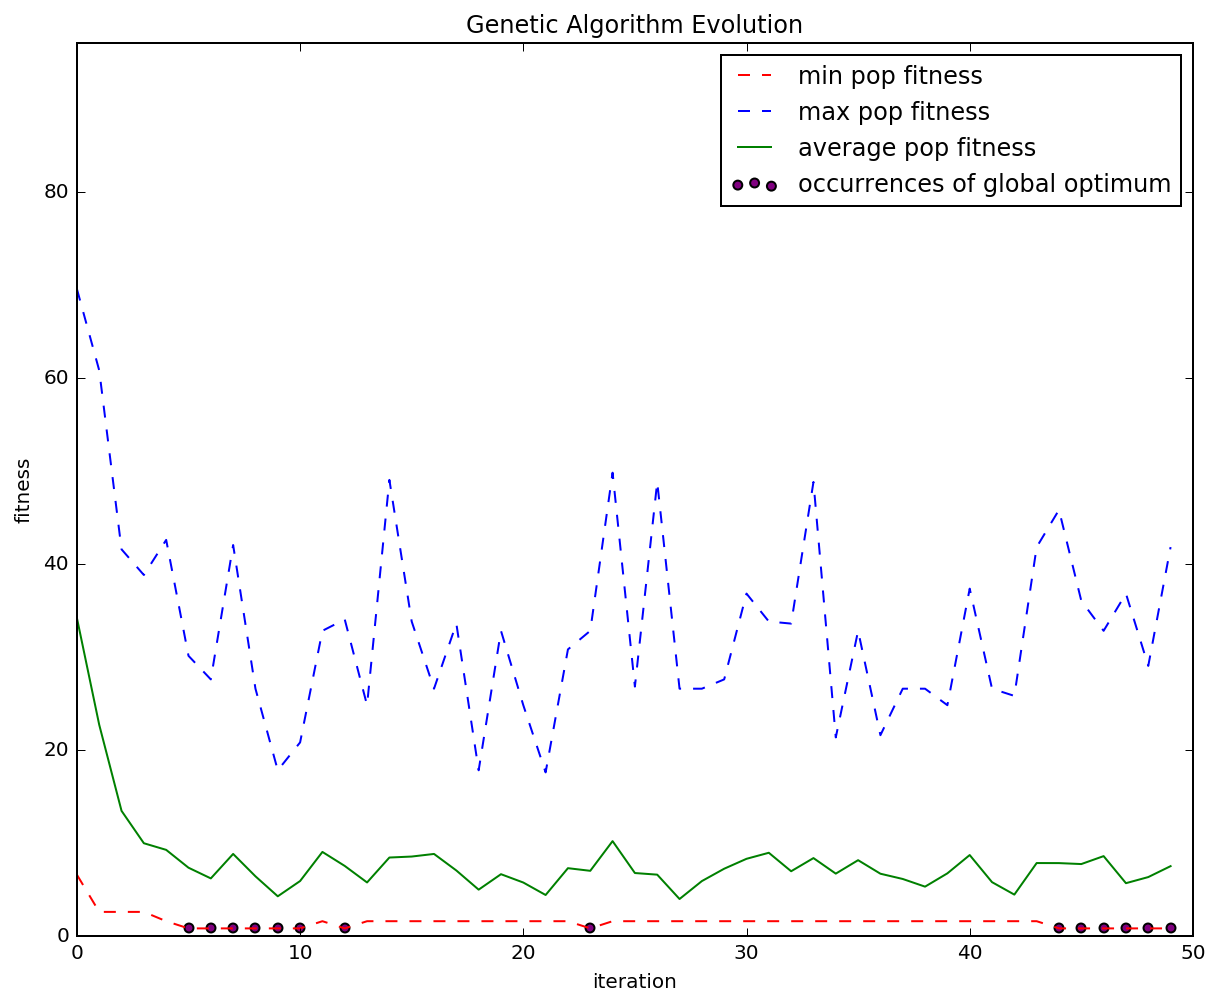

Global optimum: 10001000011010000000
OF = 0.7743999999999999
Decoded global optimum: [0.0, 0.0, -0.8799999999999999, 0.0, -0.0]


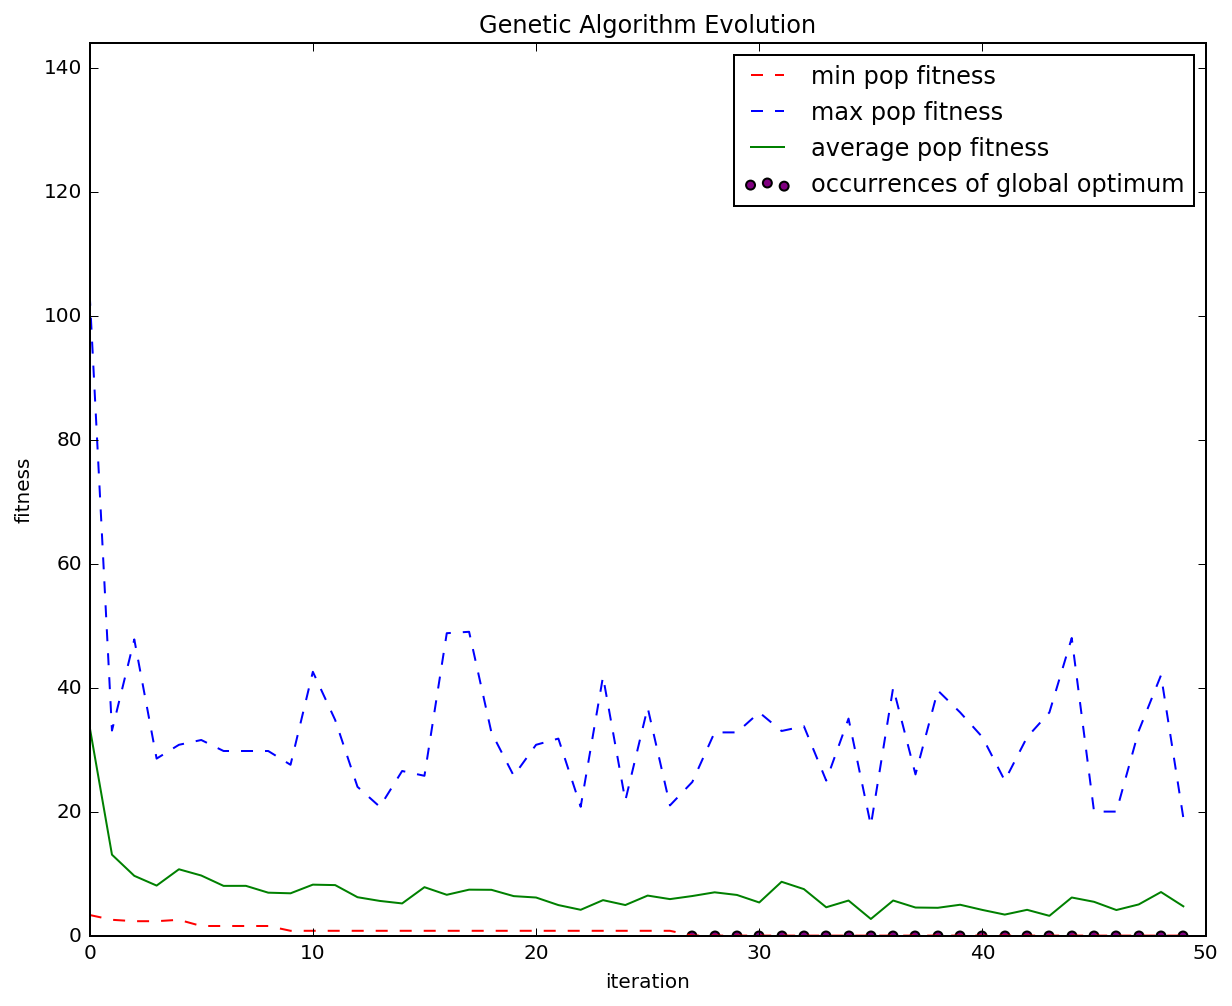

Global optimum: 00001000100000001000
OF = 0.0
Decoded global optimum: [-0.0, 0.0, 0.0, -0.0, 0.0]


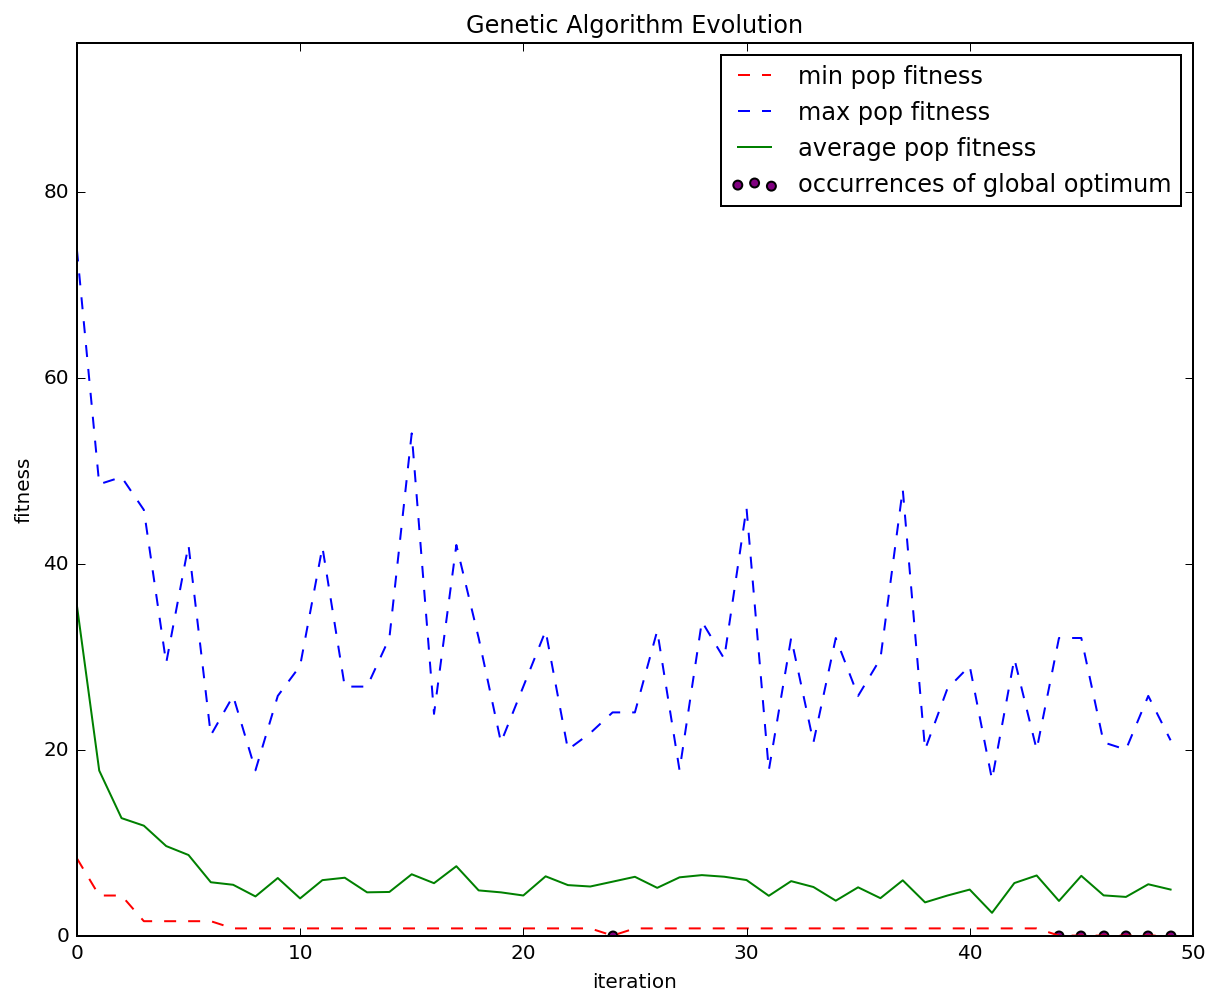

Global optimum: 10001000100010001000
OF = 0.0
Decoded global optimum: [0.0, 0.0, 0.0, 0.0, 0.0]


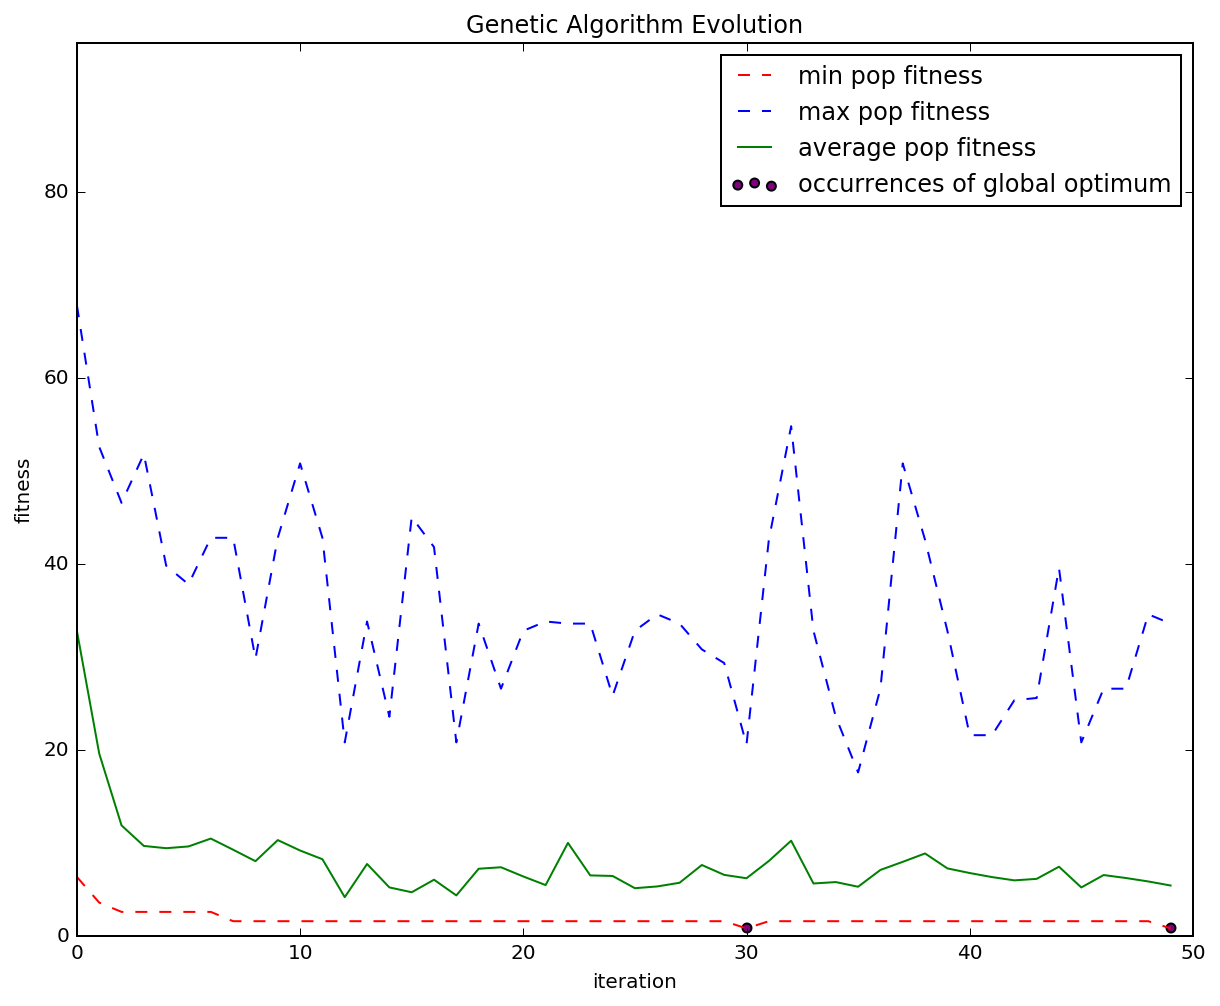

Global optimum: 10001000000011101000
OF = 0.7743999999999999
Decoded global optimum: [0.0, 0.0, -0.0, 0.8799999999999999, 0.0]


In [9]:
decoder = dejong_decoder
obj_fun = dejong_OF

fitness = lambda coding: obj_fun(*decoder(coding))

for i in range(4):
    run_genetic_algorithm(
        fitness, min_or_max=MIN, num_eras=50, 
        population_size=40, chromosome_length=20, 
        crossover_probability=0.3, mutation_probability=0.04
        
    )

## Rosenbrock

Optimal where all values $x_i = 1$.

This does better when more mutation is allowed and there are a few more eras.

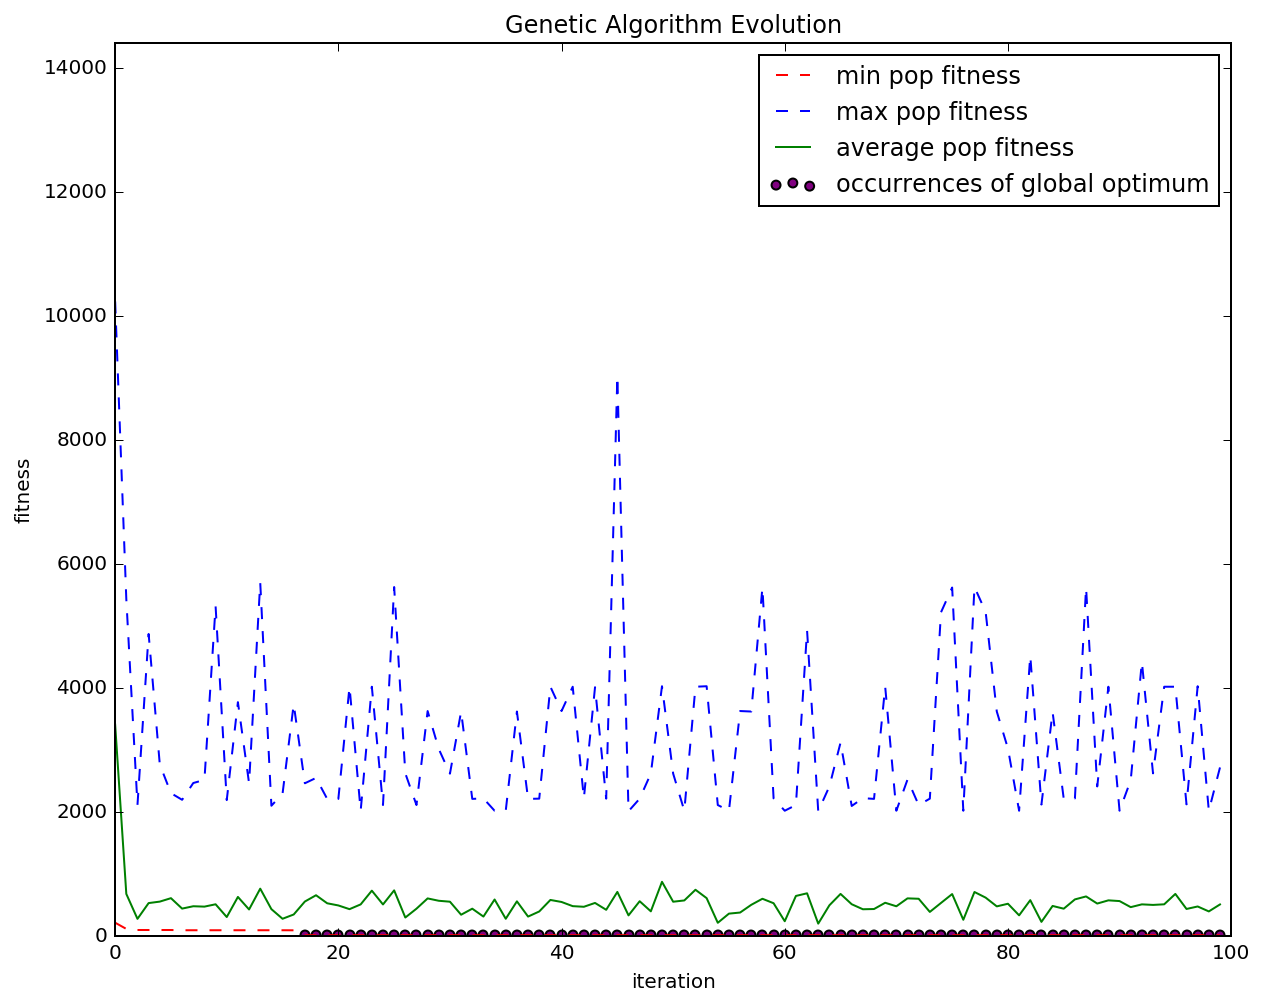

Global optimum: 00010010000000010010
OF = 6.0
Decoded global optimum: [-0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0]
---------------------------------------------------------------------------


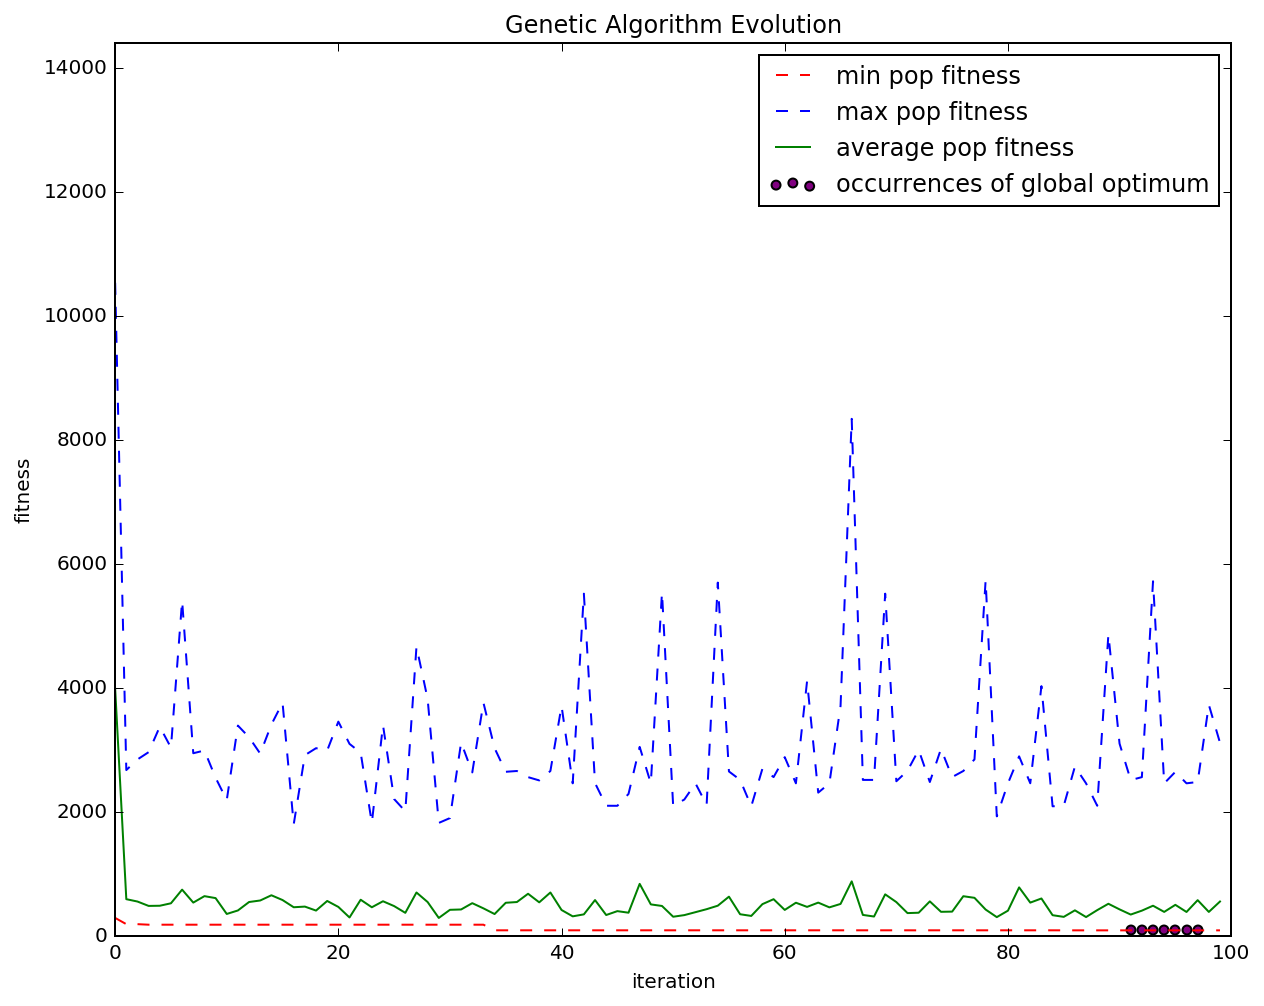

Global optimum: 10110110111110010000
OF = 84.37139804159997
Decoded global optimum: [1.0, 1.0, 1.0, 0.952, 0.0, 0.0, -0.0]
---------------------------------------------------------------------------


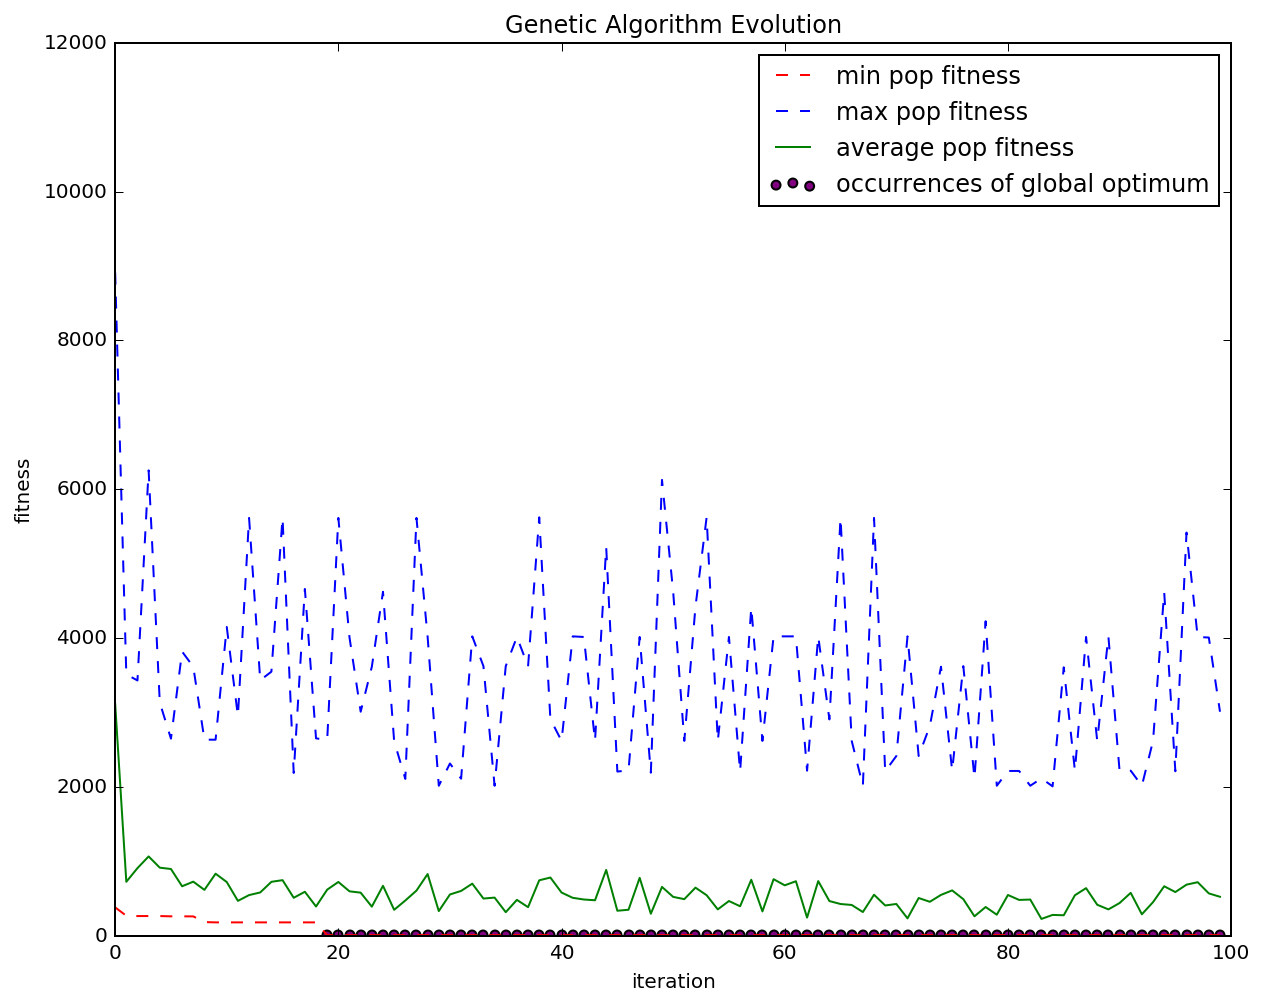

Global optimum: 10000000010010010010
OF = 6.0
Decoded global optimum: [0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0]
---------------------------------------------------------------------------


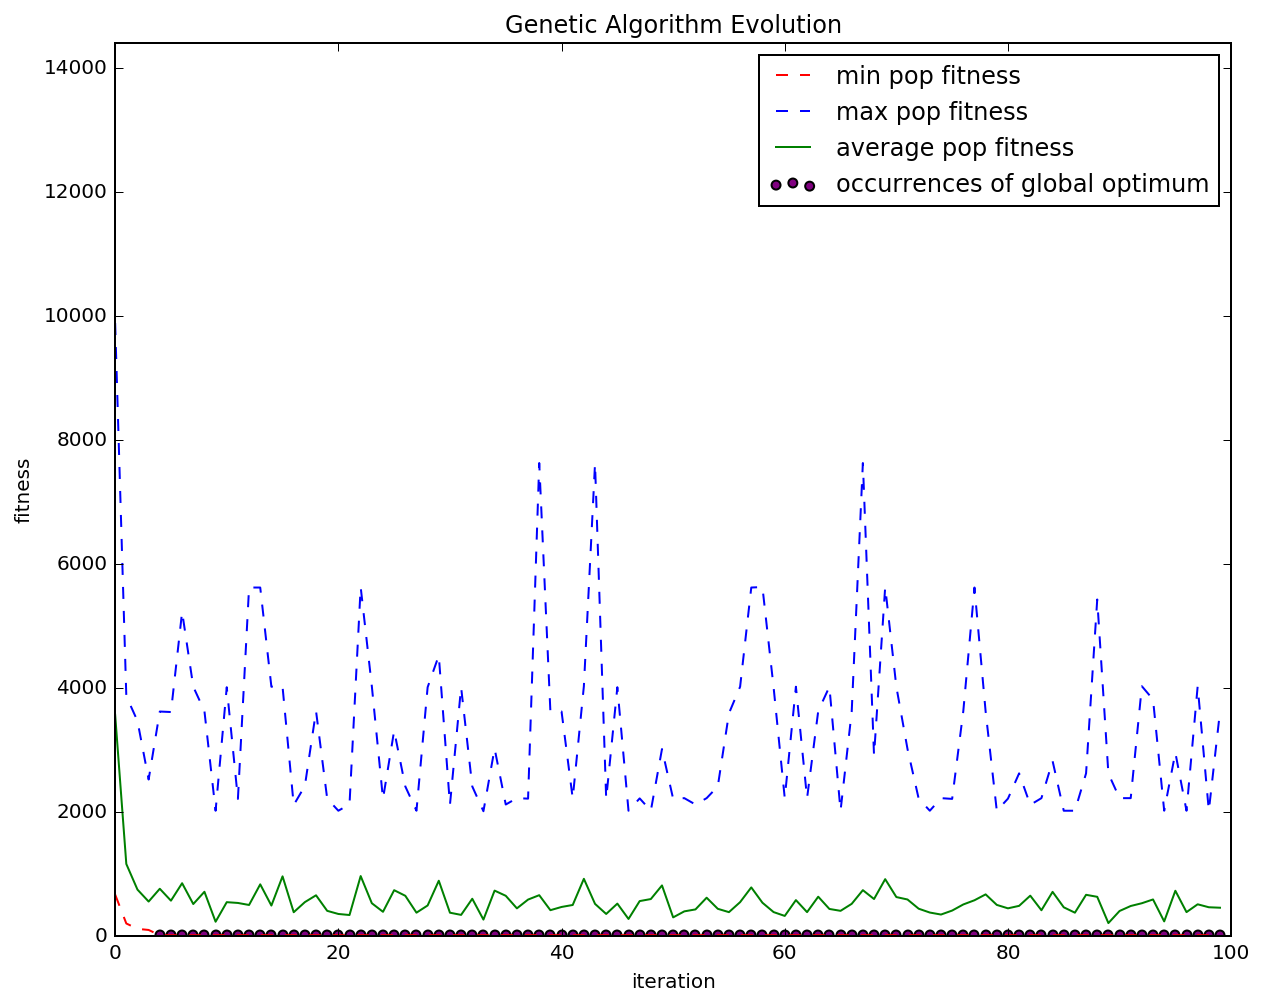

Global optimum: 10000000010010010010
OF = 6.0
Decoded global optimum: [0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0]
---------------------------------------------------------------------------


In [10]:
decoder = rosenbrock_decoder
obj_fun = rosenbrock_OF

fitness = lambda coding: obj_fun(*decoder(coding))

for i in range(4):
    run_genetic_algorithm(
        fitness, min_or_max=MIN, num_eras=100, 
        population_size=40, chromosome_length=20, 
        crossover_probability=0.35, mutation_probability=0.04
    )
    print("---------------------------------------------------------------------------")

## Himmelblau


It has one local maximum at $x = -0.270845 $ and $y = -0.923039 $ where $f(x,y) = 181.617 $, and four identical local minima:

* $f(3.0, 2.0) = 0.0, $

* $f(-2.805118, 3.131312) = 0.0, $

* $f(-3.779310, -3.283186) = 0.0, $

* $f(3.584428, -1.848126) = 0.0. $

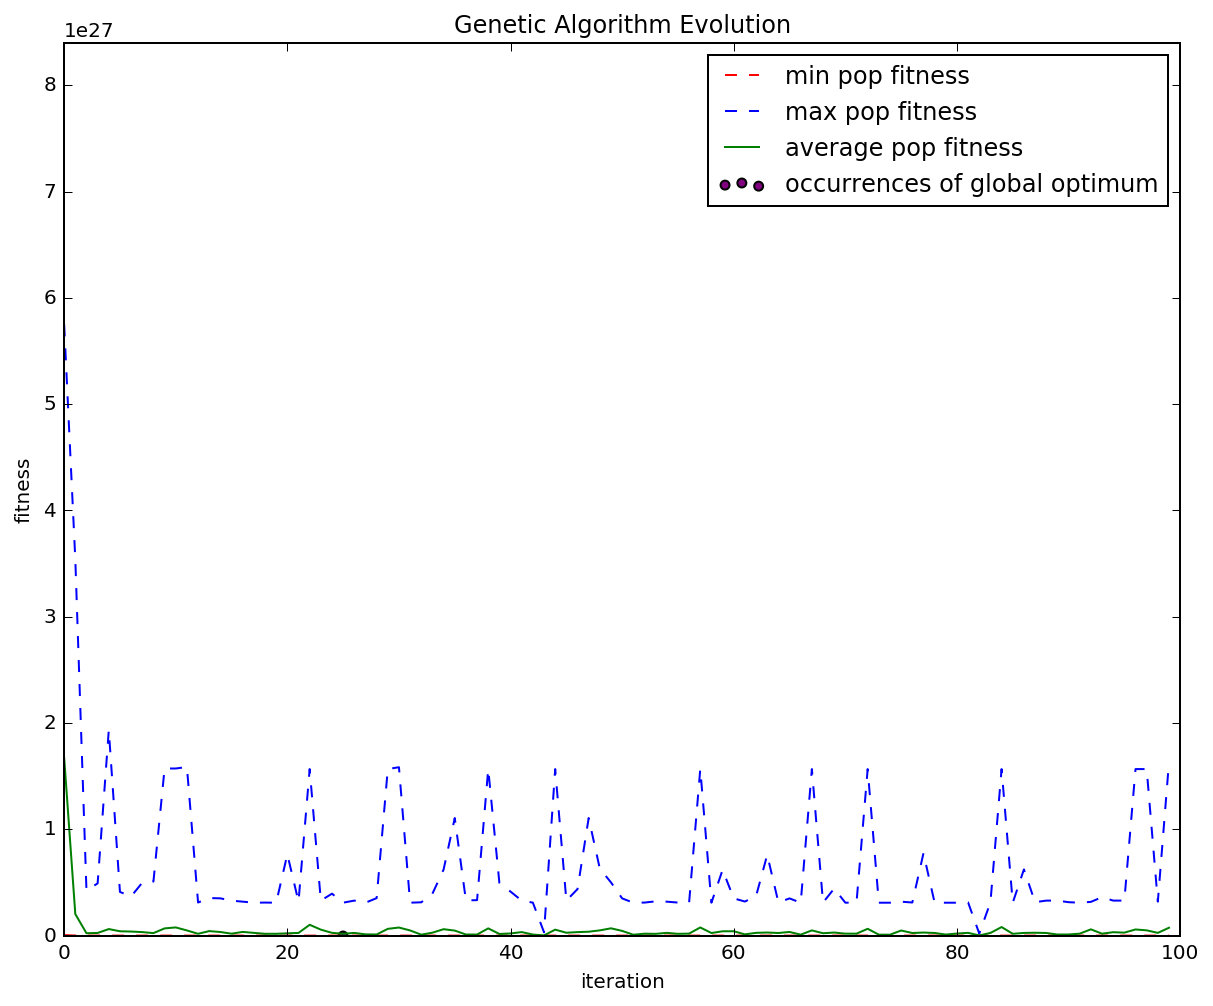

Global optimum: 0000000000000000000000001011000000000000000000000000000110000011
OF = 0.7847066011891002
Decoded global optimum: (-3.65625, -3.244140625)
---------------------------------------------------------------------------


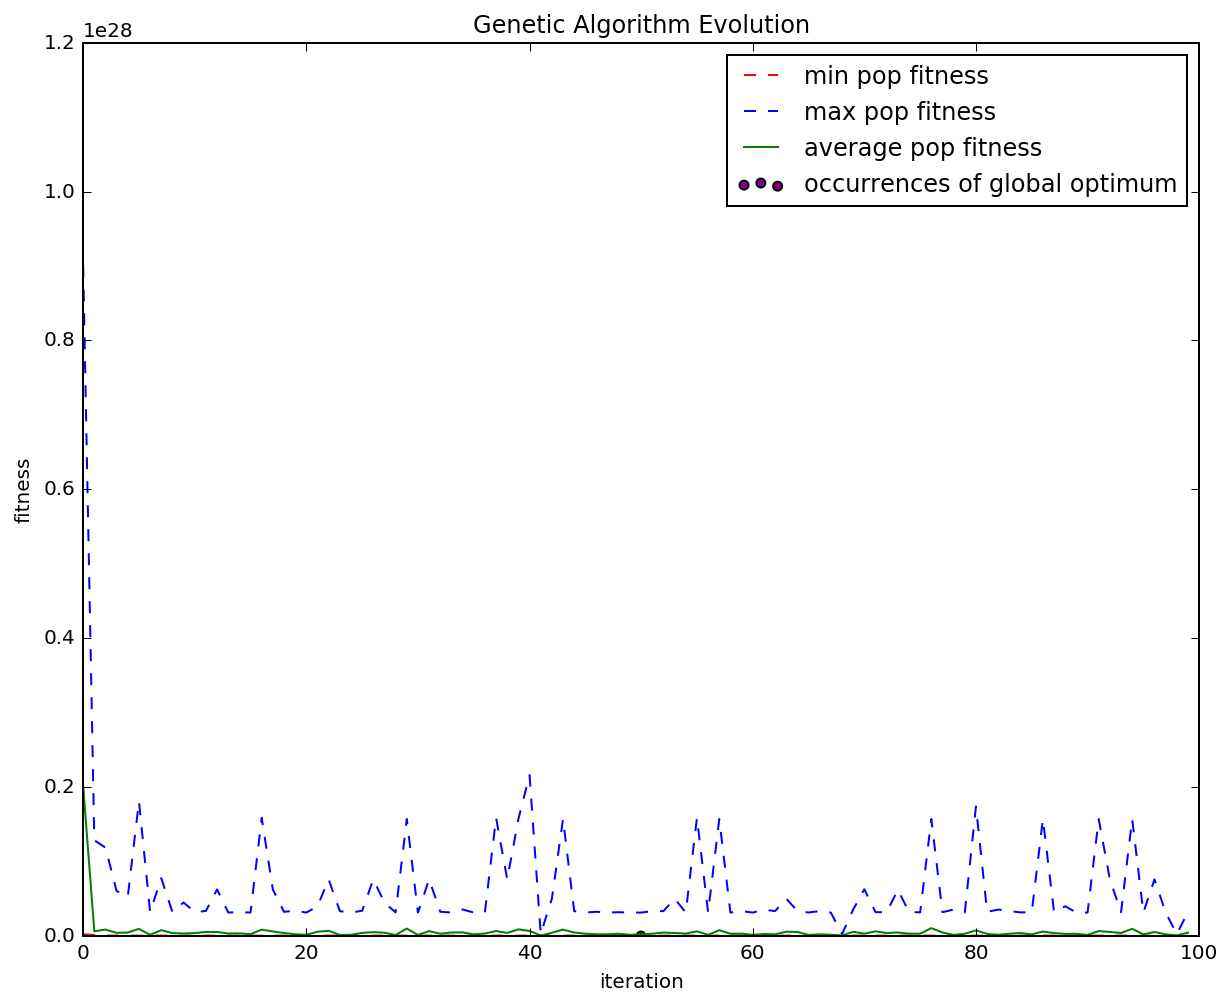

Global optimum: 0000000000000000000000001000011000000000000000000000000110000000
OF = 0.10666342475451529
Decoded global optimum: (-3.73828125, -3.25)
---------------------------------------------------------------------------


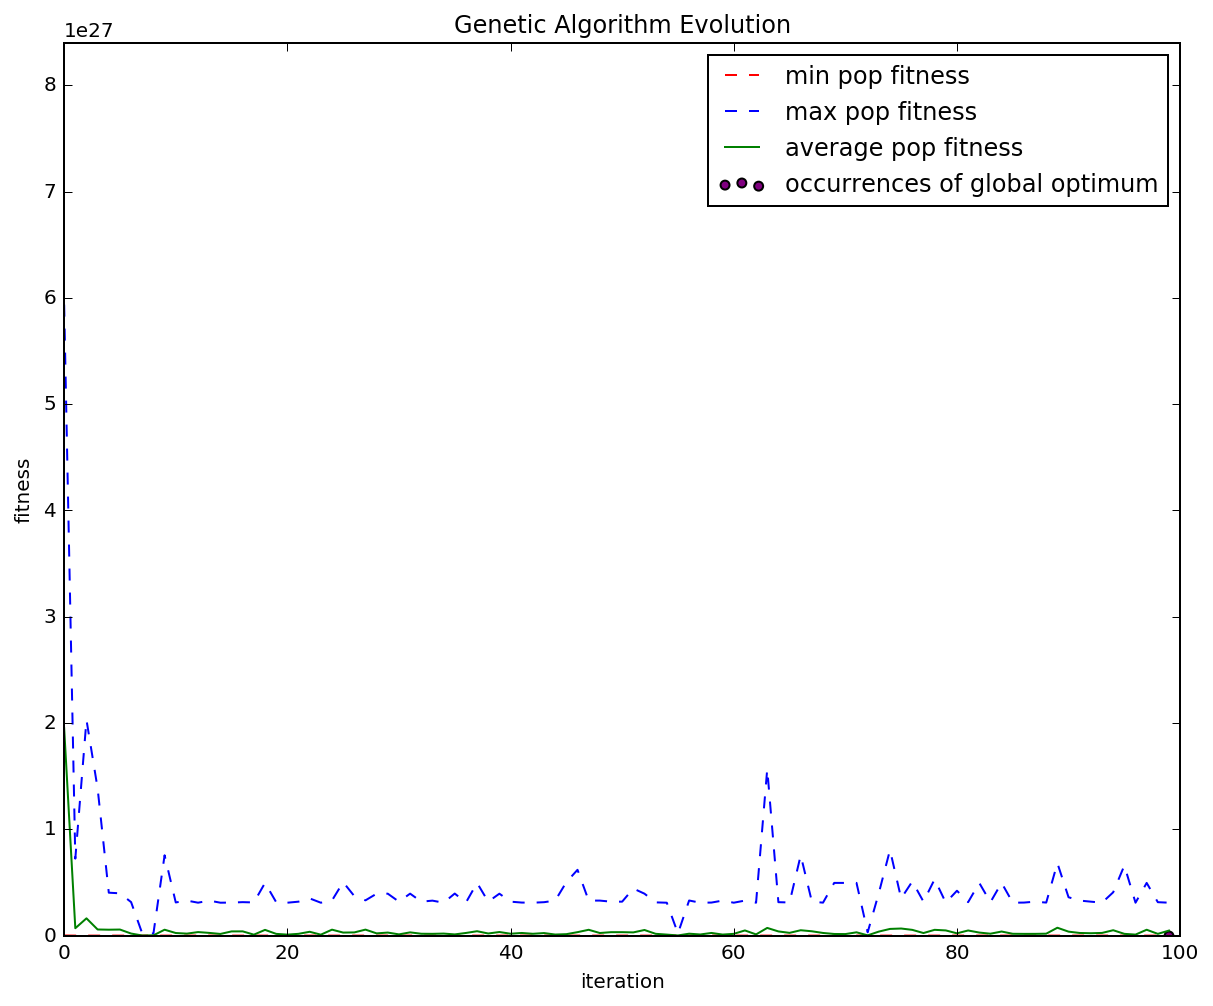

Global optimum: 0000000000000000000000001000001000000000000000000000000010110111
OF = 6.733223999632173
Decoded global optimum: (-3.74609375, -3.642578125)
---------------------------------------------------------------------------


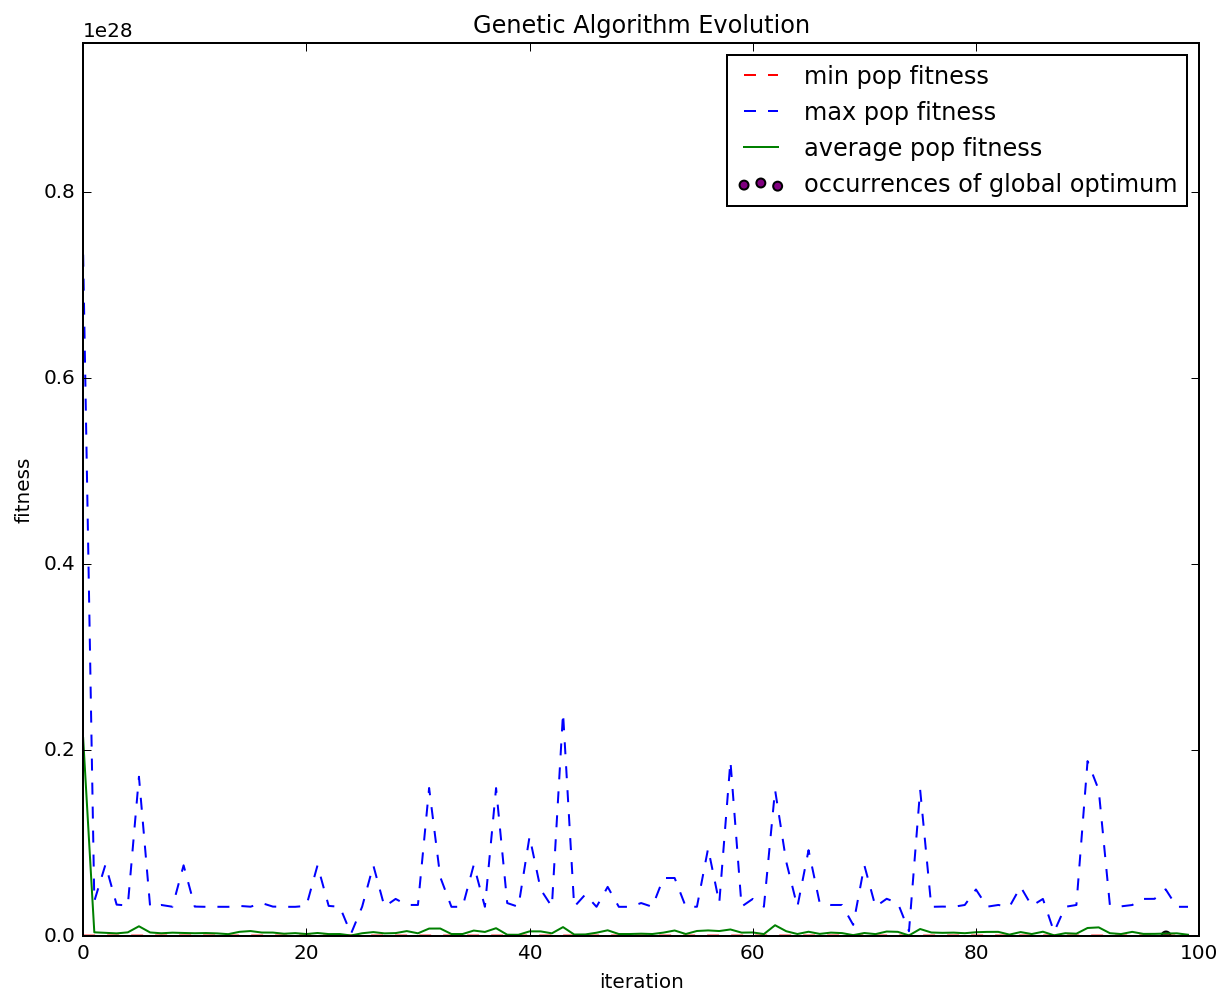

Global optimum: 0000000000000000000000100110001100000000000000000000110111111111
OF = 0.6852612824004609
Decoded global optimum: (-2.806640625, 2.998046875)
---------------------------------------------------------------------------


In [11]:
decoder = himmelblau_decoder
obj_fun = himmelblau_OF

fitness = lambda coding: obj_fun(*decoder(coding))

for i in range(4):
    run_genetic_algorithm(
        fitness, min_or_max=MIN, num_eras=100, 
        population_size=40, chromosome_length=64, 
        crossover_probability=0.35, mutation_probability=0.04
    )
    print("---------------------------------------------------------------------------")

## ESF benchmarks

These are the benchmarks provided by Dr. Kotsireas.

### Simple brute force checker for minima and maxima

This small routine generates all binary strings of length `nov` and computes the fitness for all of those strings.

This is a simple way to find the global optima for the ESF benchmarks, but it is slow for more than 15 variables or so since there are $2^{\text{nov}}$ binary strings length `nov`.

In [12]:
def solve_esf(nov, fitness):
    all_binstrings = ["{:0{width}b}".format(i, width=nov) for i in range(2**nov)]
    the_min = min(all_binstrings, key=fitness)
    the_max = max(all_binstrings, key=fitness)
    return (the_min, the_max)


def solve_and_print(nov, of):
    fitness = lambda binstring: of(*benchmark_decoder(binstring))
    the_min, the_max = solve_esf(nov, fitness)
    print('nov{}  =>  min fitness = {:<4}  max fitness = {:<4}'.format(nov, fitness(the_min), fitness(the_max)))

## ESF benchmarks in SGA

### NOV = 12

In [13]:
solve_and_print(12, nov12)

nov12  =>  min fitness = 2     max fitness = 66  


** NOV = 12, MAX = 66 **

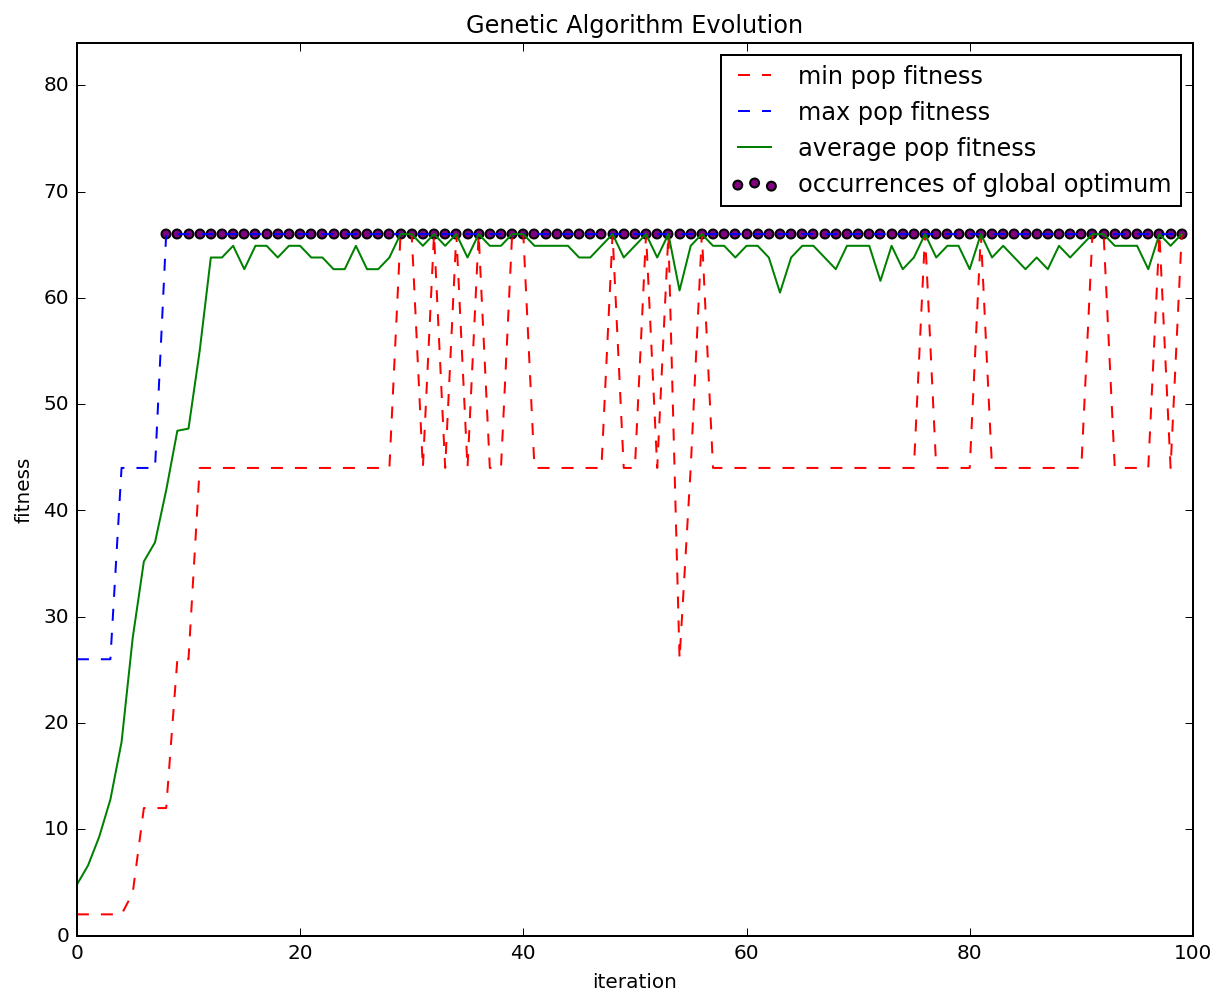

Global optimum: 000000000000
OF = 66
Decoded global optimum: [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [14]:
decoder = benchmark_decoder
nov = 12
obj_fun = nov12
fitness = lambda coding: obj_fun(*decoder(coding))

run_genetic_algorithm(fitness, chromosome_length = nov, min_or_max = MAX)

** NOV = 12, MIN = 2 **

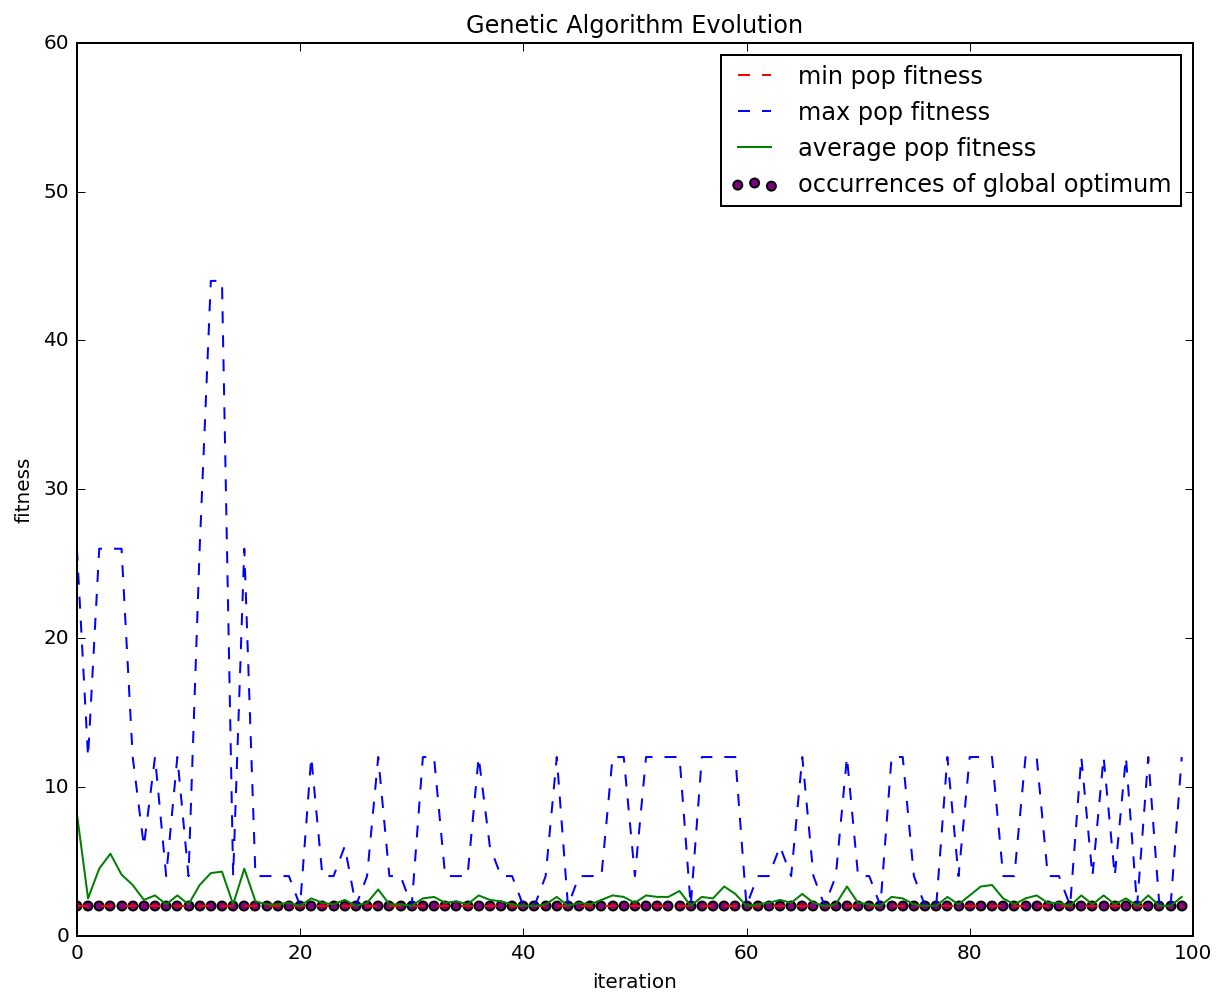

Global optimum: 011111100110
OF = 2
Decoded global optimum: [0, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1]


In [15]:
decoder = benchmark_decoder
nov = 12
obj_fun = nov12
fitness = lambda coding: obj_fun(*decoder(coding))

run_genetic_algorithm(fitness, chromosome_length = nov, min_or_max = MIN)

### NOV = 14

In [16]:
solve_and_print(14, nov14)

nov14  =>  min fitness = 1     max fitness = 91  


** NOV = 14, MAX = 91 **

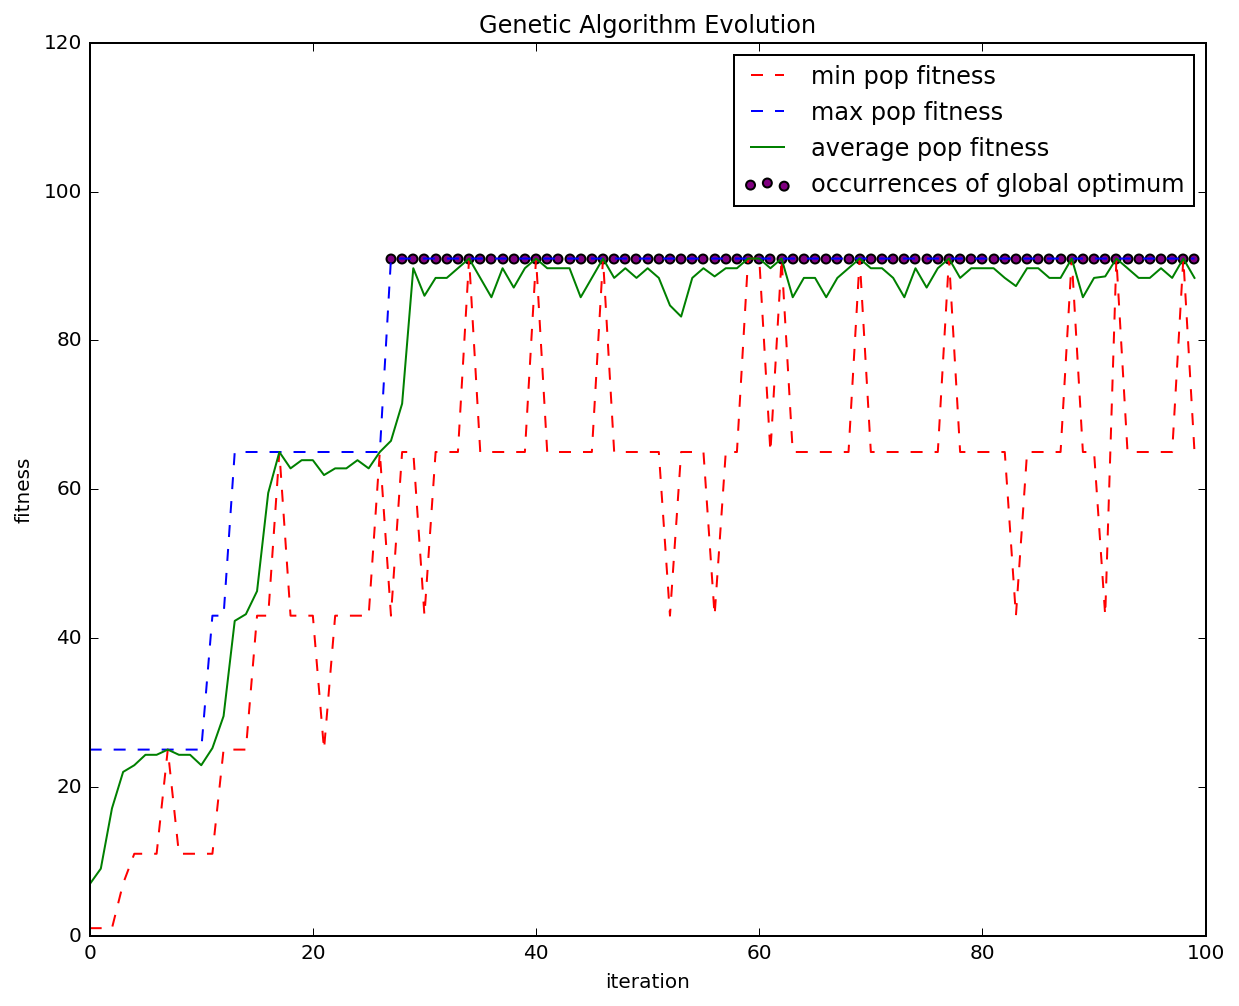

Global optimum: 00000000000000
OF = 91
Decoded global optimum: [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [17]:
decoder = benchmark_decoder
nov = 14
obj_fun = nov14
fitness = lambda coding: obj_fun(*decoder(coding))

run_genetic_algorithm(fitness, chromosome_length = nov, min_or_max=MAX)

** NOV = 14, MIN = 1 **

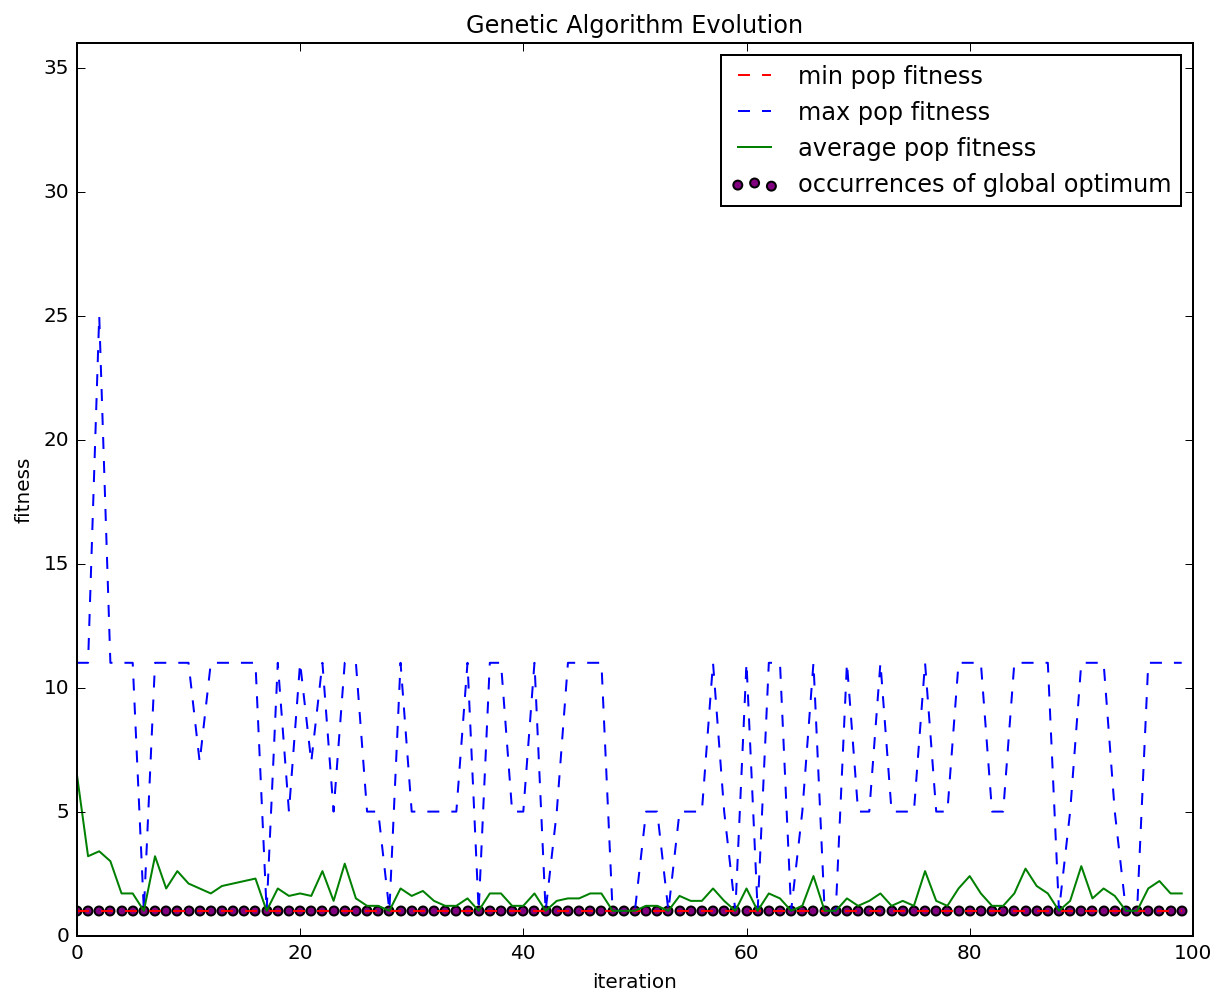

Global optimum: 11010001000001
OF = 1
Decoded global optimum: [0, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1]


In [18]:
decoder = benchmark_decoder
nov = 14
obj_fun = nov14
fitness = lambda coding: obj_fun(*decoder(coding))

run_genetic_algorithm(fitness, chromosome_length = nov, min_or_max=MIN)

### NOV = 27

** MIN and MAX not solved with brute force **

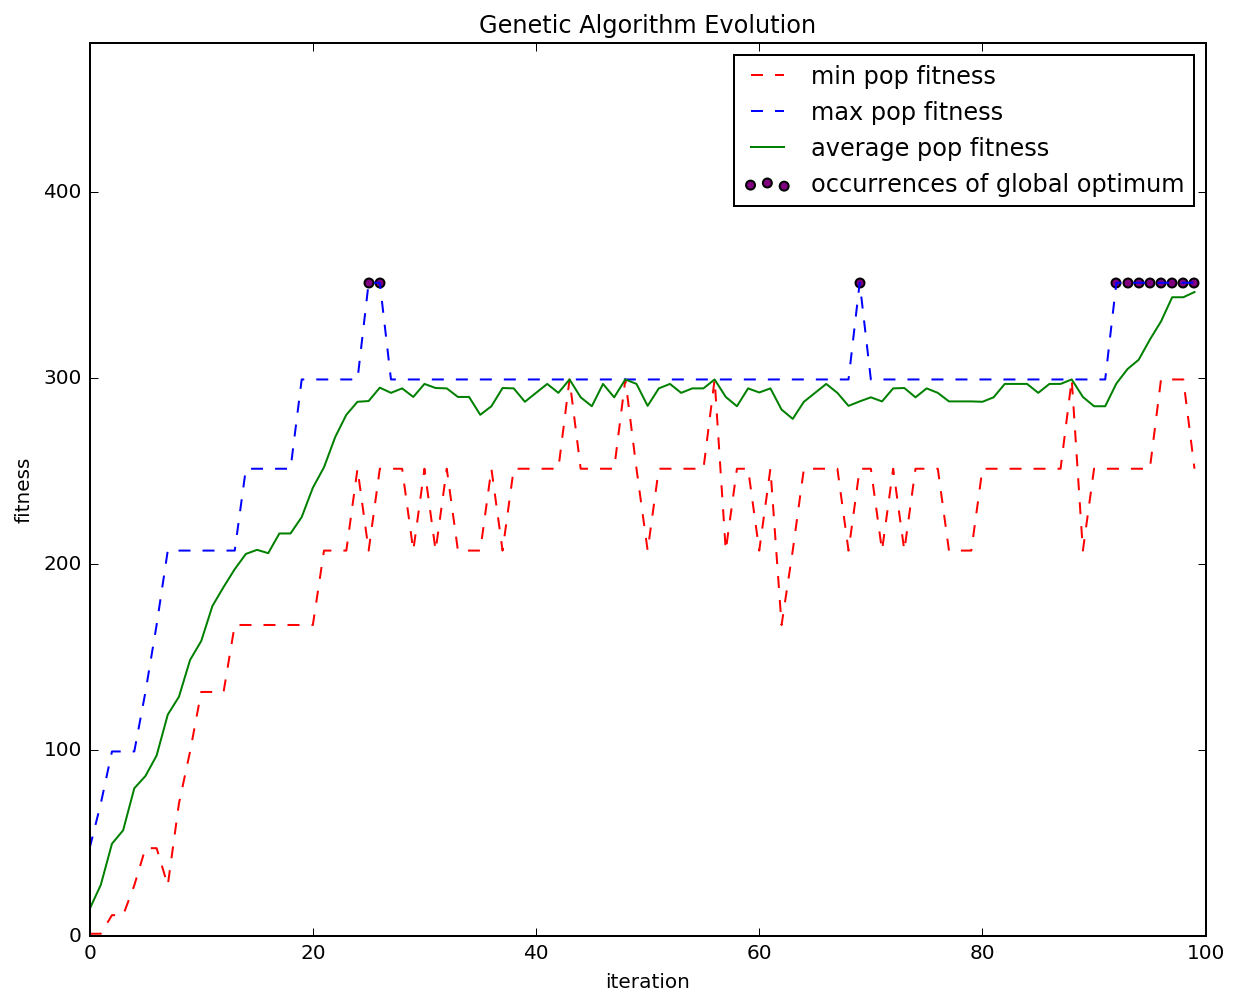

Global optimum: 000000000000000000000000000
OF = 351
Decoded global optimum: [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [19]:
decoder = benchmark_decoder
nov = 27
obj_fun = nov27
fitness = lambda coding: obj_fun(*decoder(coding))

run_genetic_algorithm(fitness, chromosome_length = nov, min_or_max=MAX, mutation_probability=0.005)

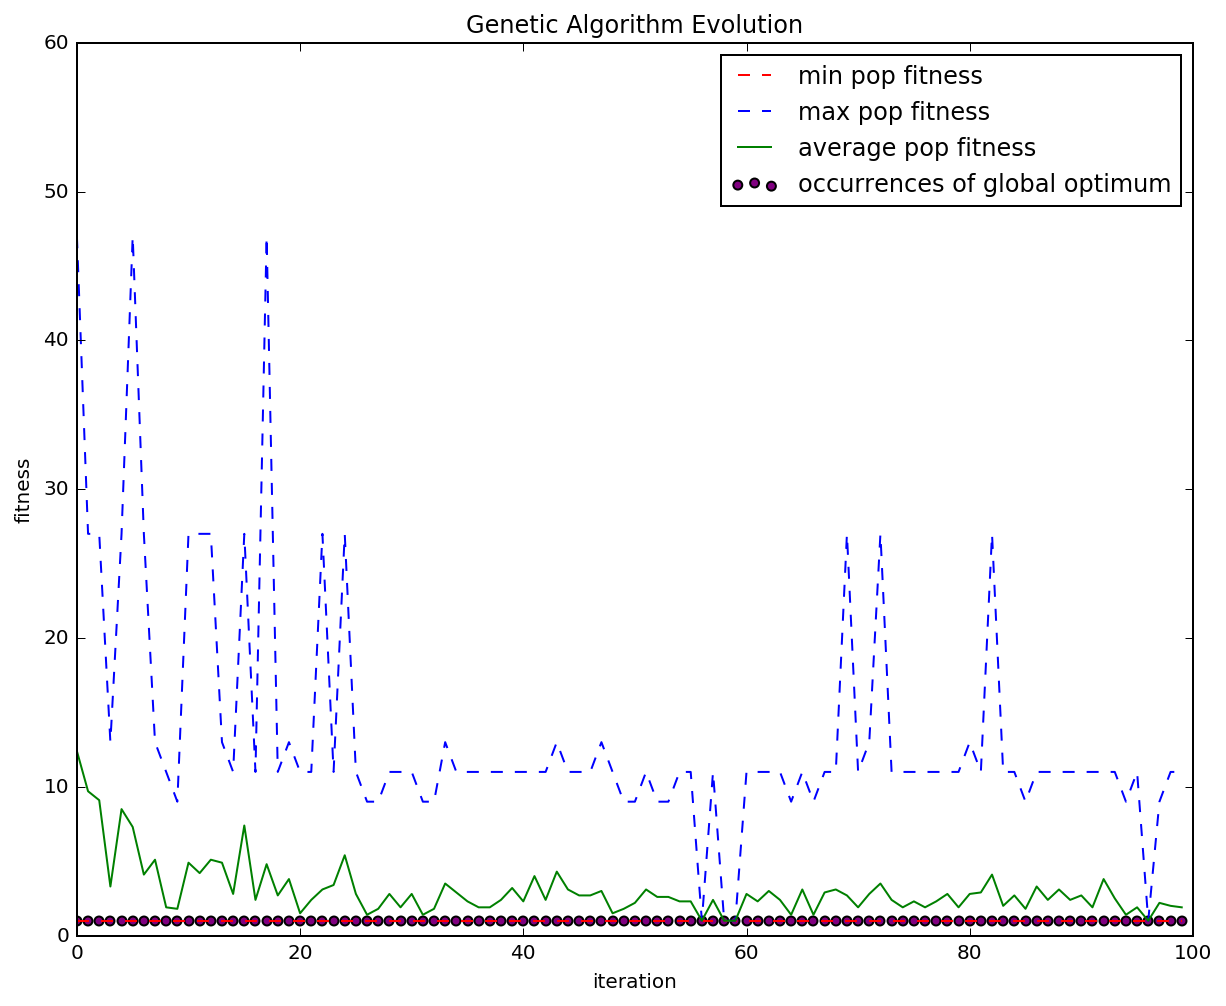

Global optimum: 010011100100110110010000001
OF = 1
Decoded global optimum: [0, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1]


In [20]:
decoder = benchmark_decoder
nov = 27
obj_fun = nov27
fitness = lambda coding: obj_fun(*decoder(coding))

run_genetic_algorithm(fitness, chromosome_length = nov, min_or_max = MIN)